In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2

In [2]:
from pprint import pprint

import flax.linen as nn
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
import pandas as pd
import seaborn as sns
from flax.training import train_state
from jax import random

from neurovae import MLPVAE, bce_loss, gaussian_kld, load_mnist, plot_digits

sns.set_theme(context="paper", style="darkgrid", rc={"axes.facecolor": "0.96"})
fontsize = "x-large"
params = {
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern"],
    "axes.labelsize": fontsize,
    "legend.fontsize": fontsize,
    "xtick.labelsize": fontsize,
    "ytick.labelsize": fontsize,
    "legend.handlelength": 2,
}
plt.rcParams.update(params)

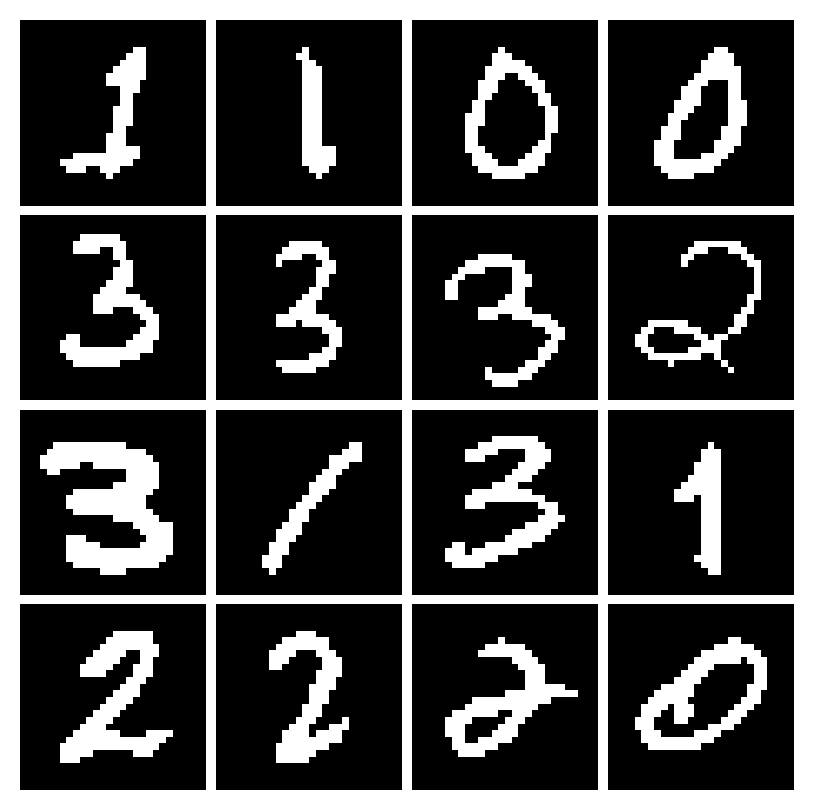

In [3]:
learning_rate = 0.001
hidden_dim = 500
latent_dim = 20
output_dim = 784
batch_size = 64
epochs = 50
seed = 42

batches, ds_test = load_mnist(
    batch_size=batch_size,
    drop_remainder=True,
    select_digits=[0, 1, 2, 3],
    as_supervised=False,
    binarized=True,
    shuffle=True,
    shuffle_seed=42,
)

# set values for learning rate scheduler
total_steps = len(batches) * epochs
init_lr = 1e-3
alpha_lr = 1e-2

jax.device_put(ds_test)

plot_digits(batches[0][:16])
plt.show()

In [4]:
def model():
    return MLPVAE(hidden_dim, latent_dim, output_dim)


def init_model(rng):
    rng, init_key = random.split(rng)

    initial_variables = jnp.ones((batch_size, output_dim), jnp.float32)
    params = model().init(init_key, initial_variables, rng)["params"]
    del initial_variables, init_key

    lr_schedule = optax.cosine_decay_schedule(init_lr, decay_steps=total_steps, alpha=alpha_lr)
    optimizer = optax.chain(optax.clip(1.0), optax.adamw(lr_schedule))
    # optimizer = optax.adam(learning_rate)

    state = train_state.TrainState.create(
        apply_fn=model().apply,
        params=params,
        tx=optimizer,
    )
    return rng, state


def compute_metrics(recon_x, x, mean, logvar):
    bce = bce_loss(recon_x, x).mean()  # mean over batch
    kld = gaussian_kld(mean, logvar).mean()  # mean over batch
    elbo = bce + kld
    return {"elbo": elbo, "bce": bce, "kld": kld}


@jax.jit
def train_step(state, batch, z_rng):

    def loss_fn(params):
        recon_x, mean, logvar = model().apply({"params": params}, batch, z_rng)
        bce = bce_loss(recon_x, batch).mean()
        kld = gaussian_kld(mean, logvar).mean()
        elbo = bce + kld
        return elbo

    grads = jax.grad(loss_fn)(state.params)
    return state.apply_gradients(grads=grads)


@jax.jit
def eval_f(params, images, z, z_rng):
    def eval_model(vae):
        recon_images, mean, logvar = vae(images, z_rng)

        recon_images_compare = nn.sigmoid(recon_images[:8])
        comparison = jnp.concatenate(
            [
                images[:8].reshape(-1, 28, 28, 1),
                recon_images_compare.reshape(-1, 28, 28, 1),
            ]
        )

        generate_images = vae.generate(z, assumption="bernoulli")
        generate_images = generate_images.reshape(-1, 28, 28, 1)
        metrics = compute_metrics(recon_images, images, mean, logvar)
        return metrics, comparison, generate_images

    return nn.apply(eval_model, model())({"params": params})

In [5]:
rng = random.key(seed)
rng, state = init_model(rng)

rng, z_key, eval_rng = random.split(rng, 3)

z = random.normal(z_key, (batch_size, latent_dim))  # prior
del z_key

epoch_metrics = []
for epoch in range(epochs):
    for batch in batches:
        rng, key = random.split(rng)
        state = train_step(state, batch, key)

    metrics, comparison, sample = eval_f(state.params, ds_test, z, eval_rng)
    metrics["epoch"] = epoch + 1
    epoch_metrics.append(metrics)
    print(f"epoch: {epoch + 1}, ELBO: {metrics['elbo']:.4f}, BCE: {metrics['bce']:.4f}, KLD: {metrics['kld']:.4f}")

epoch: 1, ELBO: 102.1546, BCE: 78.0394, KLD: 24.1152
epoch: 2, ELBO: 92.5443, BCE: 66.5741, KLD: 25.9702
epoch: 3, ELBO: 89.1434, BCE: 62.0562, KLD: 27.0872
epoch: 4, ELBO: 86.9824, BCE: 60.8154, KLD: 26.1669
epoch: 5, ELBO: 85.5722, BCE: 58.1254, KLD: 27.4468
epoch: 6, ELBO: 84.3463, BCE: 57.4331, KLD: 26.9132
epoch: 7, ELBO: 83.3687, BCE: 55.6694, KLD: 27.6992
epoch: 8, ELBO: 83.3791, BCE: 56.2136, KLD: 27.1655
epoch: 9, ELBO: 82.9270, BCE: 55.3119, KLD: 27.6151
epoch: 10, ELBO: 82.0410, BCE: 54.8644, KLD: 27.1767
epoch: 11, ELBO: 81.6878, BCE: 53.3672, KLD: 28.3205
epoch: 12, ELBO: 81.1142, BCE: 53.2035, KLD: 27.9108
epoch: 13, ELBO: 80.9797, BCE: 53.2474, KLD: 27.7323
epoch: 14, ELBO: 80.9312, BCE: 53.2461, KLD: 27.6851
epoch: 15, ELBO: 80.6609, BCE: 52.4333, KLD: 28.2276
epoch: 16, ELBO: 80.3695, BCE: 52.3381, KLD: 28.0314
epoch: 17, ELBO: 80.2936, BCE: 51.8819, KLD: 28.4116
epoch: 18, ELBO: 80.0572, BCE: 51.8729, KLD: 28.1843
epoch: 19, ELBO: 79.7136, BCE: 51.2249, KLD: 28.4887
e

In [6]:
state.step

Array(19300, dtype=int32, weak_type=True)

In [7]:
df = pd.DataFrame(epoch_metrics)
df

,bce,elbo,kld,epoch
0,78.03942,102.15464,24.115215,1
1,66.574135,92.5443,25.970165,2
2,62.056206,89.14342,27.087212,3
3,60.815414,86.98236,26.166943,4
4,58.125423,85.57221,27.446787,5
5,57.4331,84.34628,26.913181,6
6,55.669426,83.36867,27.69924,7
7,56.213577,83.37911,27.165531,8
8,55.311924,82.92703,27.615107,9
9,54.86436,82.04102,27.17666,10


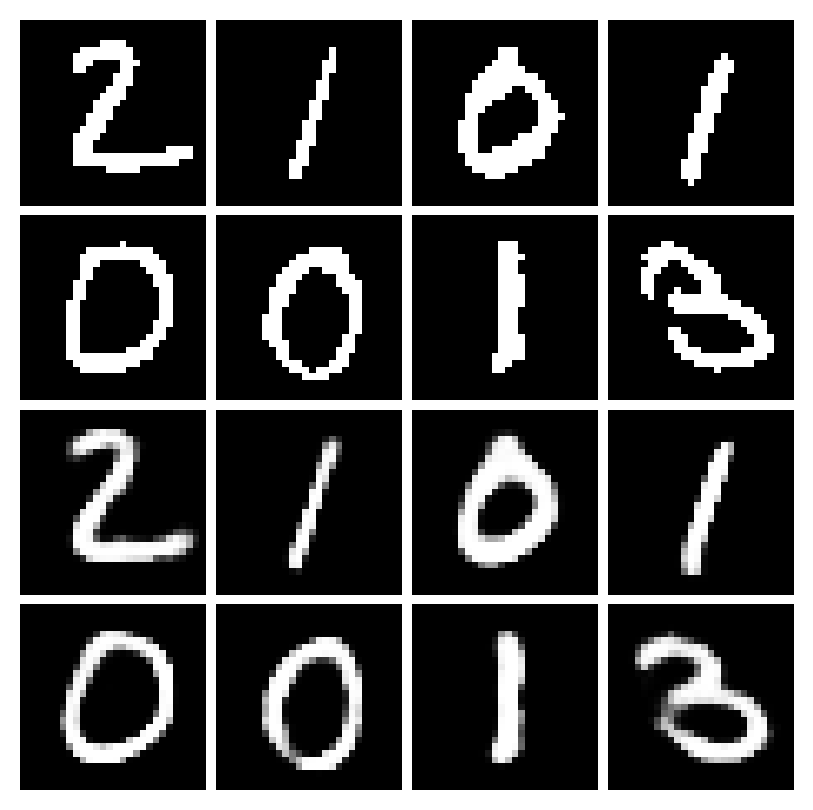

In [8]:
plot_digits(comparison)
plt.show()

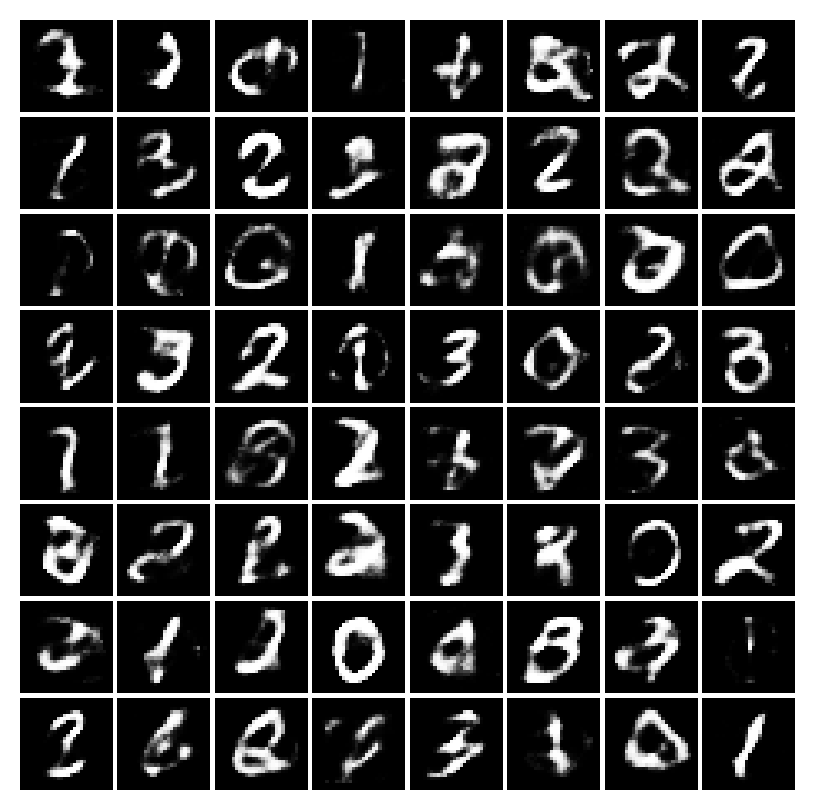

In [9]:
plot_digits(sample)
plt.show()

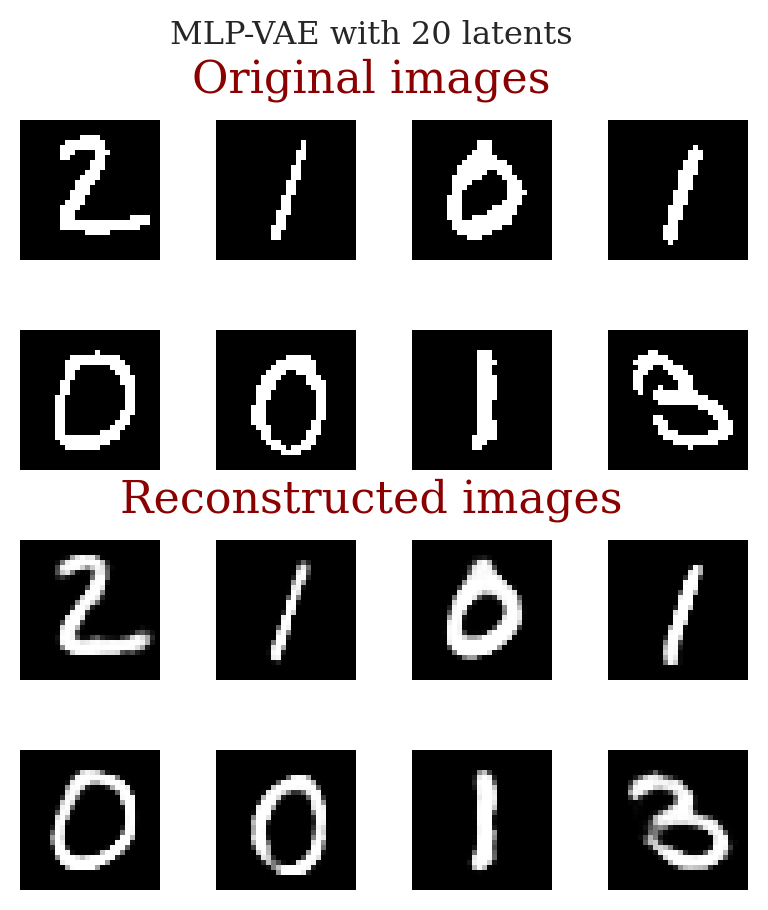

In [30]:
from experiments.plot_utils import plot_comparison

plot_comparison(comparison)